### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras_tuner import HyperModel, Hyperband

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


In [3]:
!nvidia-smi
# !kill -9 <PID>

Thu Apr 10 15:02:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A30                     Off |   00000000:25:00.0 Off |                    0 |
| N/A   28C    P0             30W /  165W |   23013MiB /  24576MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Data Preprocessing

In [4]:
wind_cols = ['uSq','Z2','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

### Data Preparation: Train-Test-Validation Split

In [5]:
H_preds = ['H_pred0','H_pred1','H_pred2','H_pred3','H_pred4']
features = scaled_wind_cols + H_preds

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = df_train1[features].values, df_train1['scaled_H'].values
X_train2, y_train2 = df_train2[features].values, df_train2['scaled_H'].values
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = df_val[features].values, df_val['scaled_H'].values
X_test, y_test = df_test[features].values, df_test['scaled_H'].values

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61344, 8)
(8760, 8)
(8784, 8)


### Model Selection and Implementation

In [ ]:
epochs = 50
batch_size = 64
model_file = 'model_stack.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, features)
        Input(shape=(X_train.shape[1],)),
        
        # Dense layers
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),
        
        # Output layer
        Dense(1),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    
    return model

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

- **Batch size**: 32, 64
- **# of layers**: 1, 2
- **# of units**: 16, 32, 64, 128
- **Dropout rate**: 0.2
- **Activation**: 'relu'
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

In [6]:
epochs = 50
batch_size = 64

class DenseHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Input layer with shape: (samples, features)
        model.add(Input(shape=(X_train.shape[1],)))
        
        # Tunable layers and units
        num_layers = hp.Int('layers', min_value=1, max_value=2, step=1)
        for i in range(num_layers):
            model.add(Dense(
                hp.Choice(f'units', values=[16, 32, 64, 128]),
                activation = 'relu',
                kernel_regularizer = regularizers.l2(0.01)))
            model.add(Dropout(0.2))
        
        # Output layer
        model.add(Dense(1))
        
        # Compile the model
        model.compile(
            optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss = 'mse',
            metrics = ['mse'],
        )
        
        return model

# Search space setup
tuner = Hyperband(
    DenseHyperModel(),
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    directory = 'hp_tuning',
    project_name = 'model_stack',
)

# Hyperparameter tuning
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

Reloading Tuner from hp_tuning/model_stack/tuner0.json


In [7]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)
print()

# Best model
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(optimizer=Adam(learning_rate=best_hp.values['learning_rate']), loss='mse', metrics=['mse'])
print(best_model.summary())

{'layers': 1, 'units': 32, 'learning_rate': 0.000493446318593248, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0078'}



I0000 00:00:1744311756.757210 4103071 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 697 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1744311760.439672 4103395 service.cc:152] XLA service 0x7f08e80048a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744311760.439694 4103395 service.cc:160]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-04-10 15:02:40.456133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744311760.523203 4103395 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744311760.964491 4103395 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


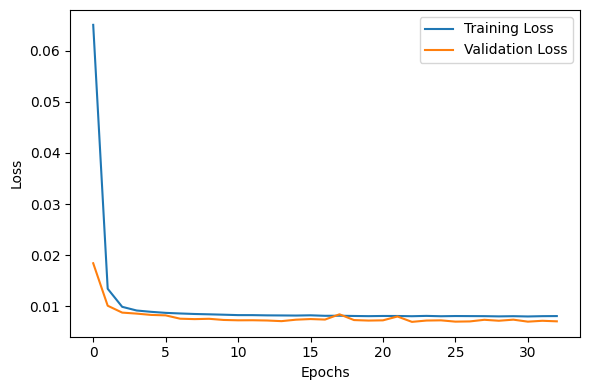

In [8]:
model_file = 'best_model_stack.keras'

# Train and save the model (architecture + weights)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [9]:
# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = scaled_wave.inverse_transform(y_pred1)
y_true1 = pd.concat([df_train1['H'], df_train2['H']], axis=0)
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1_raw)):.3f}')

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = scaled_wave.inverse_transform(y_pred2)
y_true2 = df_val['H']
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2_raw)):.3f}')

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = scaled_wave.inverse_transform(y_pred3)
y_true3 = df_test['H']
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')

Training RMSE: 0.881
Validation RMSE: 0.832
Test RMSE: 0.796


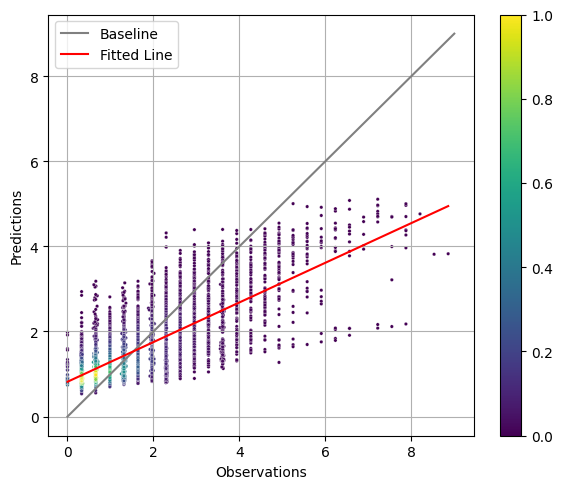

In [10]:
def pred_vs_obs(y_true, y_pred):
    y_pred = y_pred.flatten()
    fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot([0, 9], [0, 9], color='grey', label='Baseline')
    ax.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true,y_pred,1))(np.unique(y_true)), color='r', label='Fitted Line')
    ax.set(xlabel='Observations', ylabel='Predictions')
    ax.legend()
    ax.grid()
    
    kernel = stats.gaussian_kde(np.vstack([y_true, y_pred]))(np.vstack([y_true, y_pred]))
    sns.scatterplot(x=y_true, y=y_pred, c=kernel, s=6, cmap='viridis', ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    
    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw)

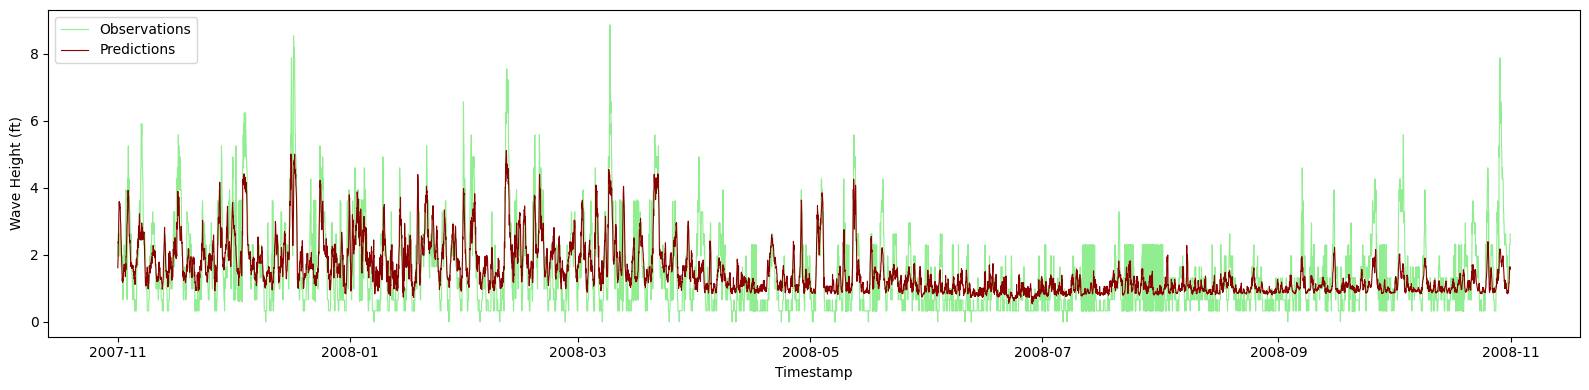

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['H'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index, y_pred3_raw, linewidth=0.8, color='darkred', label='Predictions')

plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()